# OCR Validator
This notebook contains a simple conceptual framework an optical character recognition (OCR) system. It is a part of the OCR subnet tutorial which can be found at XXXXX.

A notebook such as this one is a suitable starting point for building a subnet. This is because it contains a well-defined incentive mechanism, which is the essence of a subnet.

# Contents
1. Define validation flow (noisy images with text)
2. Define incentive mechanism (a reward function)
3. Define miner (pytesseract)

In [1]:
!pip install h5py
!pip install typing-extensions
!pip install wheel
!pip install bittensor PyMuPDF editdistance reportlab Pillow faker scipy plotly nbformat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 661.6 kB/s eta 0:00:0000:0100:01


In [2]:
import os
import io
import math
import time
import fitz
import torch
import random
import datetime
import editdistance

import bittensor as bt
import plotly.express as px

from faker import Faker
from typing import List
from PIL import Image, ImageFilter, ImageDraw
from scipy.optimize import linear_sum_assignment

from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.pdfbase import pdfmetrics

seed = 0
fake = Faker()
# Seed the Faker instance
fake.seed_instance(seed)

# set random seed
random.seed(seed)

# 1. Validation flow

Validation in this subnet consists of creating a pdf document (synthetic data generation) with ground truth data (pdf contents), and scoring miner responses based on how accurately they extract the contents. This can be thought of as a straightforward supervised learning problem.

### Synthetic data generation
We choose to create synthetic invoice documents as the basis for validation. Faker is a very useful library that can be used to generate a plethora of different data types, and it is ideal for our quick prototype.

In [3]:
# example usage of faker
for _ in range(5):
    print(f'Name: {fake.name():<20}, Phone: {fake.phone_number():<24}, City: {fake.city():<12}')

Name: Norma Fisher        , Phone: 487-364-7593x824        , City: Vanessaside 
Name: Dr. Stephanie Collins, Phone: 001-915-678-1565x9387   , City: Port Samanthatown
Name: Ryan Page           , Phone: +1-909-375-3513x93328   , City: West Nancyfort
Name: Juan Mann           , Phone: +1-358-839-8947         , City: Barbaraport 
Name: Roberto Johnson     , Phone: +1-547-511-2201x86848   , City: Rileymouth  


In [4]:
def create_invoice(invoice_data, filename):
    """
    Generates an invoice from raw data and saves as pdf

    Args:
    - invoice_data (dict): contents of invoice
    - filename (str): path to save pdf file

    Returns:
    - List[dict]: contents of invoice with text, position and font information for each section
    """

    c = canvas.Canvas(filename, pagesize=letter)
    w, h = c._pagesize
    c.setLineWidth(.3)

    font_name = random.choice(['Helvetica','Times-Roman'])
    font_size = random.choice([10, 11, 12])
    c.setFont(font_name, font_size)

    data = []
    def write_text(x, y, text):
        c.drawString(x, y, text)
        # scale x and y by the page size and estimate bounding box based on font size
        # position = [x0, y0, x1, y1]
        text_width = pdfmetrics.stringWidth(text, font_name, font_size)
        position = [
            x/w,
            1 - (y - 0.2*font_size)/h,
            (x + text_width)/w,
            1 - (y + 0.8*font_size)/h
        ]

        data.append({'position': position, 'text': text, 'font': {'family': font_name, 'size': font_size}})

    # Draw the invoice header
    write_text(30, 750, invoice_data['company_name'])

    write_text(400, 750, "Invoice Date: " + invoice_data['invoice_date'])
    write_text(400, 735, "Invoice #: " + invoice_data['invoice_number'])

    write_text(30, 735, invoice_data['company_address'])
    write_text(30, 720, invoice_data['company_city_zip'])

    # Draw the bill to section
    write_text(30, 690, "Bill To:")
    write_text(120, 690, invoice_data['customer_name'])

    # Table headers
    write_text(30, 650, "Description")
    write_text(300, 650, "Qty")
    write_text(460, 650, "Cost")
    c.line(30, 645, 560, 645)

    # List items
    line_height = 625
    total = 0
    for item in invoice_data['items']:
        write_text(30, line_height, item['desc'])
        write_text(300, line_height, str(item['qty']))
        write_text(460, line_height, "${:.2f}".format(item['cost']))
        total += item['qty'] * item['cost']
        line_height -= 15

    # Draw the total cost
    write_text(400, line_height - 15, f"Total: ${total:,.2f}" )

    # Terms and Conditions
    write_text(30, line_height - 45, "Terms:")
    write_text(120, line_height - 45, invoice_data['terms'])

    c.save()
    return data



In [5]:
# Create a list of optional items for the invoice
items_list = [
    {"desc": "Web hosting", "cost": 100.00},
    {"desc": "Domain registration", "cost": 10.00},
    {"desc": "SSL certificate", "cost": 5.50},
    {"desc": "Web design", "cost": 500.00},
    {"desc": "Web development", "cost": 500.00},
    {"desc": "SEO", "cost": 100.00},
    {"desc": "Content creation", "cost": 300.00},
    {"desc": "Social media marketing", "cost": 400.00},
    {"desc": "Email marketing", "cost": 150.00},
    {"desc": "PPC advertising", "cost": 200.00},
    {"desc": "Analytics", "cost": 400.00},
    {"desc": "Consulting", "cost": 700.00},
    {"desc": "Training", "cost": 1200.00},
    {"desc": "Maintenance", "cost": 650.00},
    {"desc": "Support", "cost": 80.00},
    {"desc": "Graphic design", "cost": 310.00},
    {"desc": "Logo design", "cost": 140.00},
    {"desc": "Branding", "cost": 750.00},
]

def random_items(n):
    """Selects n items at random (with exclusion) and adds a random quantity"""
    items = sorted(random.sample(items_list, k=n), key=lambda x: x['desc'])
    return [{**item, 'qty':random.randint(1,5)} for item in items]

random_items(5)

[{'desc': 'Domain registration', 'cost': 10.0, 'qty': 4},
 {'desc': 'Email marketing', 'cost': 150.0, 'qty': 4},
 {'desc': 'Maintenance', 'cost': 650.0, 'qty': 3},
 {'desc': 'Training', 'cost': 1200.0, 'qty': 4},
 {'desc': 'Web development', 'cost': 500.0, 'qty': 3}]

In [6]:

# Sample data for the invoice, populated with faker
invoice_info = {
    "company_name": fake.company(),
    "company_address": fake.address(),
    "company_city_zip": f'{fake.city()}, {fake.zipcode()}',
    "company_phone": fake.phone_number(),
    "customer_name": fake.name(),
    "invoice_date": datetime.date.fromtimestamp(1700176424-random.random()*5e8).strftime("%B %d, %Y"),
    "invoice_number": f"INV{random.randint(1,10000):06}",
    "items": random_items(random.randint(5,20)),
    "terms": f"Payment due within {random.choice([7, 14, 30, 60, 90])} days"
}

# Fille the invoice template with our synthetic data and save as a pdf
pdf_filename = "sample_invoice.pdf"
data = create_invoice(invoice_info, pdf_filename)

# returned data is the 'ground truth' labels which are used to score miner responses
data[:3]

[{'position': [0.049019607843137254,
   0.05606060606060603,
   0.16558823529411765,
   0.040909090909090895],
  'text': 'Keller-Davies',
  'font': {'family': 'Helvetica', 'size': 12}},
 {'position': [0.6535947712418301,
   0.05606060606060603,
   0.916281045751634,
   0.040909090909090895],
  'text': 'Invoice Date: August 19, 2014',
  'font': {'family': 'Helvetica', 'size': 12}},
 {'position': [0.6535947712418301,
   0.07499999999999996,
   0.8410653594771241,
   0.05984848484848482],
  'text': 'Invoice #: INV003579',
  'font': {'family': 'Helvetica', 'size': 12}}]

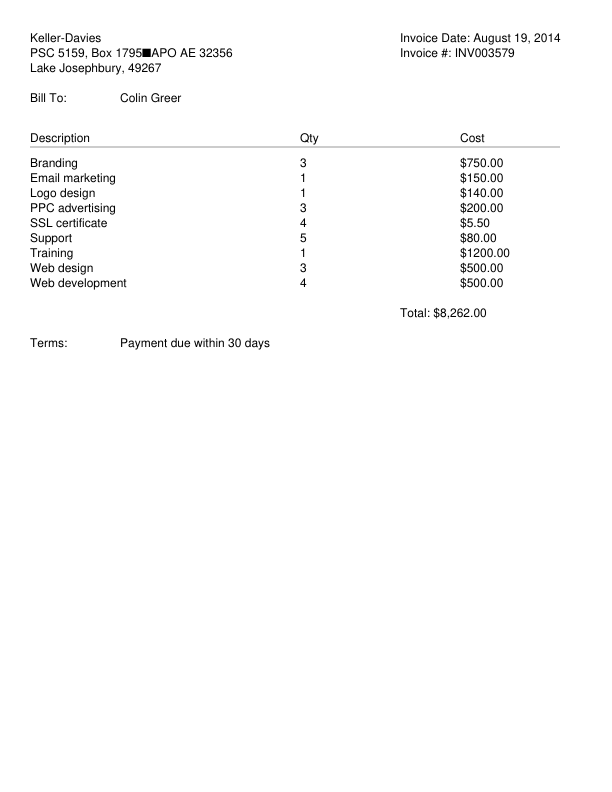

In [7]:
def load_image(pdf_path, page=0, zoom_x=1.0, zoom_y=1.0):
    """Loads pdf image and converts to PIL image"""
    # Read the pdf into memory
    pdf = fitz.open(pdf_path)
    page = pdf[page]

   # Set zoom factors for x and y axis (1.0 means 100%)
    mat = fitz.Matrix(zoom_x, zoom_y)
    pix = page.get_pixmap(matrix=mat)
    img_data = io.BytesIO(pix.tobytes('png'))

    # convert to PIL image
    return Image.open(img_data)

image = load_image(pdf_filename)
image

In [18]:

from io import BytesIO
import hashlib
def serialize_image(image, format="JPEG"):
    """Converts PIL image to base64 string.
    """

    buffer = BytesIO()
    image.save(buffer, format=format)
    return buffer.getvalue()

base64_image = serialize_image(image)
hashlib.md5(base64_image).hexdigest()

'3137ab1b42d885a9526b5587369114f4'

In [8]:
def corrupt_image(input_pdf_path, output_pdf_path, border=50, noise=0.1, spot=(100,100), scale=0.95, theta=0.2, blur=0.5):
    """Applies transformations to pdf in order to make the document harder to parse"""

    image = load_image(input_pdf_path, zoom_x=1.5, zoom_y=1.5)

    width, height = image.size

    # # imitate curled page by making the top-right and bottom-left corners go slightly up and darkening the edges
    if border is not None:
        for x in range(1,border):
            tone = 256 - int(250*(x/border-1)**2)
            for y in range(height):
                # only update color if the pixel is white
                if min(image.getpixel((x,y))) < 20:
                    continue
                image.putpixel((x, y), (tone, tone, tone))
                image.putpixel((width-x, y), (tone, tone, tone))

    # Apply noise
    if noise is not None:
        draw = ImageDraw.Draw(image)
        for _ in range(int(width * height * noise)):
            x = random.randint(0, width - 1)
            y = random.randint(0, height - 1)
            # TODO: Parameterize
            delta = random.gauss(0,10)
            rgb = tuple([int(min(max(0,val+delta),256)) for val in image.getpixel((x,y))])
            draw.point((x, y), fill=rgb)

    if spot is not None:
        draw = ImageDraw.Draw(image)
        for _ in range(int(width * height * noise)):
            x = random.randint(0, width - 1)
            y = random.randint(0, height - 1)
            #TODO: Parameterize
            delta = 10000 / (1 + math.sqrt((spot[0]-x)**2 + (spot[1]-y)**2))
            rgb = tuple([int(min(max(0,val-delta),256)) for val in image.getpixel((x,y))])
            draw.point((x, y), fill=rgb)

    # rescale the image within 10% to 20%
    if scale is not None:
        image = image.resize(size=(int(scale*width), int(scale*height)))

    # apply a rotation
    if theta is not None:
        image = image.rotate(theta, expand=True)

    # Apply blur
    if blur is not None:
        image = image.filter(ImageFilter.GaussianBlur(blur))

    # Save processed images back as a PDF
    image.save(output_pdf_path, "PDF", resolution=100.0, save_all=True)

    print(f"Saved {output_pdf_path}")

noisy_pdf_filename = 'noisy_invoice.pdf'
corrupt_image( pdf_filename, noisy_pdf_filename)


Saved noisy_invoice.pdf


## Quick sanity check
Here we overlay the ground truth labels with the noisy document

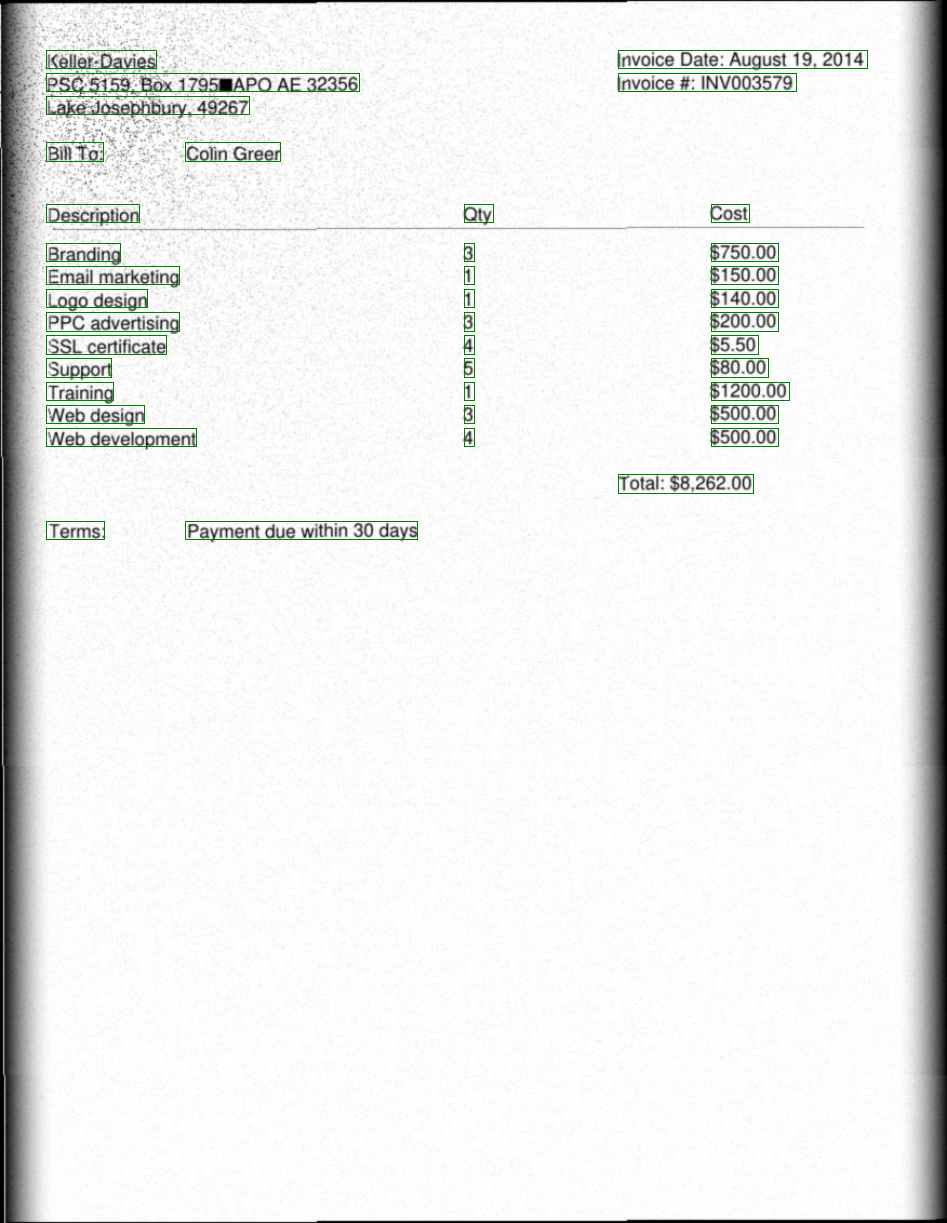

In [9]:
def draw_boxes(image, response, color='red'):
    """Draws boxes around text on the image"""
    draw = ImageDraw.Draw(image)
    for item in response:
        draw.rectangle(item['position'], outline=color)
    return image

def scale_data(data: List[dict], w: int, h: int):
    """
    Rescales the position data so that it matches the image size.
    In other words, convert position from relative to page size to absolute.

    Args:
        data (List[dict]): List of dictionaries containing the position, font and text of each section
        w (int): Width of the image
        h (int): Height of the image

    Returns:
        List[dict]: List of dictionaries containing the position, font and text of each section
    """
    scaled_data = []
    for section in data:
        entry = section.copy()
        p = section['position']
        # convert to absolute units in pixels
        entry['position'] = [p[0]*w, p[3]*h, p[2]*w, p[1]*h]
        scaled_data.append(entry)

    return scaled_data

# Here we show our ground truth labels overlaid on the document
noisy_image = load_image(noisy_pdf_filename, zoom_x=1.5, zoom_y=1.5)
scaled_data = scale_data(data, *noisy_image.size)
draw_boxes(noisy_image.copy(), scaled_data, color='green')

# 2. Incentive mechanism


- Simplest option is just to measure the similarity between true text and the OCR model's predicted text.
- More challenging is require miners to provide positional information about text (bounding boxes/ sections of text)
- More challenging still is to provide 'metadata' about text (font, size, color, etc.). Possibly even equations, tables, etc.
- Ideal outcome is to get the miner to give html + css to reproduce the exact document (denoised). Even some way of handling embedded images.

**Use case for this would be to easily extract and reproduce a webpage, presentation slide or even a photo of an object.**



Loss function for OCR model:

$$ L = \sum_i \alpha_p L^p_i + \alpha_f L^f_i + \alpha_t L^t_i $$

where

$ L^p_i $ is the loss for section i based on positional/layout correctness. This should be zero if the OCR model returns the exact box on the page.

We propose that the positional loss is the intersection over union of the bounding boxes:
$$ L^p_i = IOU(\hat{b}_i, b_i) $$

where $ \hat{b}_i $ is the predicted bounding box and $ b_i $ is the ground truth bounding box.


$ L^f_i $ is the loss for section i based on font correctness. This should be zero if the OCR model returns the exact font for the section, including font family, font size and perhaps even colors.

We propose that the font loss is a delta between the predicted font and the ground truth font plus the square of the difference in font size:
$$ L^f_i = \alpha_f^f (1 - \delta(\hat{f}_i, f_i) )+ \alpha_f^s (\hat{s}_i - s_i)^2 $$

$ L^t_i $ is the loss for section i based on text correctness. This should be zero if the OCR model returns the exact text for the section.

We propose that the text loss is the edit distance between the predicted text and the ground truth text:
$$ L^t_i = ED(\hat{t}_i, t_i) $$

where $ ED $ is the edit distance function. This is equivalent to the Levenshtein distance.

$ \alpha_p, \alpha_f, \alpha_t $ are weights for each of the loss terms. These will impact the difficulty of the OCR challenge as text correctness is likely much easier than position correctness etc.

We will convert the loss to produce a reward which is to be maximized by the miner. To do this we will trivially subtract the loss from 1 for each term.

$$ R = \sum_i \alpha_p (1 - L^p_i) + \alpha_f (1 - L^f_i) + \alpha_t (1 - L^t_i) $$

where $ L $ is the loss function defined above. This probably some epsilon to avoid division by zero.

Lastly, we will include a time penalty to encourage miners to respond quickly. This will be a linear penalty based on the time taken to respond.

$$ R_{total} = \alpha_{prediction}  R + \alpha_{time} t $$

where $ t $ is the time taken to respond.

## A Note on desired schema

As we want to score based on attributes beyond just the text we require that miners respond with the following schema:
```python
response = [
    {'index':0, 'position':[x1, x2, y1, y2], 'font_family':'Times New Roman', 'font_size':12, 'text':'Hello World!'},
    ...
]
```

We can also build in some deisrable default behaviour in case the miner is unable to do the task in the desired way:
- If response is a `str`, then we just assume that the order of sections is correct and the text is correct.
- If response is a `List[str]`, then we assume that the order of sections is correct but the text is not.
- If response is a `List[dict]`, then we assume that the miner has provided all the information we need.

Missing fields incur the maximum loss for that field.

After some experimentation we find that the reward is highly sensitive to the order of the sections. This is not ideal as it means that the miner must also predict the order of the sections. We can solve this by automatically sort the predicted sections using the Hungarian algorithm. This is a simple linear assignment problem which will minimize the total distance between the predicted and ground truth sections.

In [10]:



def get_position_reward(boxA: List[float], boxB: List[float] = None):
    """
    Calculate the intersection over union (IoU) of two bounding boxes.

    Args:
    - boxA (list): Bounding box coordinates of box A in the format [x1, y1, x2, y2].
    - boxB (list): Bounding box coordinates of box B in the format [x1, y1, x2, y2].

    Returns:
    - float: The IoU value, ranging from 0 to 1.
    """
    if not boxB:
        return 0.0

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = intersection_area / float(boxA_area + boxB_area - intersection_area)

    return iou

def get_text_reward(text1: str, text2: str = None):
    """
    Calculate the edit distance between two strings.

    Args:
    - text1 (str): The first string.
    - text2 (str): The second string.

    Returns:
    - float: The edit distance between the two strings. Normalized to be between 0 and 1.
    """
    if not text2:
        return 0.0

    return 1 - editdistance.eval(text1, text2) / max(len(text1), len(text2))

def get_font_reward(font1: dict, font2: dict = None, alpha_size=1.0, alpha_family=1.0):
    """
    Calculate the distance between two fonts, based on the font size and font family.

    Args:
    - font1 (dict): The first font.
    - font2 (dict): The second font.

    Returns:
    - float: The distance between the two fonts. Normalized to be between 0 and 1.
    """
    if not font2:
        return 0.0

    font_size_score = ( 1 - abs(font1['size'] - font2['size']) / max(font1['size'], font2['size']) )
    font_family_score = alpha_family * float(font1['family'] == font2['family'])
    return (alpha_size * font_size_score + alpha_family * font_family_score) / (alpha_size + alpha_family)

def section_reward(label: dict, pred: dict, alpha_p=1.0, alpha_f=1.0, alpha_t=1.0, verbose=False):
    """
    Score a section of the image based on the section's correctness.
    Correctness is defined as:
    - the intersection over union of the bounding boxes,
    - the delta between the predicted font and the ground truth font,
    - and the edit distance between the predicted text and the ground truth text.

    Args:
    - label (dict): The ground truth data for the section.
    - pred (dict): The predicted data for the section.

    Returns:
    - float: The score for the section. Bounded between 0 and 1.
    """
    reward = {
        'text': get_text_reward(label['text'], pred.get('text')),
        'position': get_position_reward(label['position'], pred.get('position')),
        'font': get_font_reward(label['font'], pred.get('font')),
    }

    reward['total'] = (alpha_t * reward['text'] + alpha_p * reward['position'] + alpha_f * reward['font']) / (alpha_p + alpha_f + alpha_t)

    if verbose:
        bt.logging.info(', '.join([f"{k}: {v:.3f}" for k,v in reward.items()]))

    return reward

def sort_predictions(image_data: List[dict], predictions: List[dict], draw=False) -> List[dict]:
    """
    Sort the predictions to match the order of the ground truth data using the Hungarian algorithm.

    Args:
    - image_data (list): The ground truth data for the image.
    - predictions (list): The predicted data for the image.

    Returns:
    - list: The sorted predictions.
    """

    # First, make sure that the predictions is at least as long as the image data
    predictions += [{}] * (len(image_data) - len(predictions))
    r = torch.zeros((len(image_data), len(predictions)))
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            r[i,j] = section_reward(image_data[i], predictions[j])['total']

    # Use the Hungarian algorithm to find the best assignment
    row_indices, col_indices = linear_sum_assignment(r, maximize=True)

    if draw:
        fig = px.imshow(r.detach().numpy(),
                    color_continuous_scale='Blues',
                    title=f'Optimal Assignment (Avg. Reward: {r[row_indices, col_indices].mean():.3f})',
                    width=600, height=600
                    )
        fig.update_layout(coloraxis_showscale=False)
        fig.update_yaxes(title_text='Ground Truth')
        fig.update_xaxes(title_text='Predictions')

        for i, j in zip(row_indices, col_indices):
            fig.add_annotation(x=j, y=i, text='+', showarrow=False, font=dict(color='red', size=16))
        fig.show()

    sorted_predictions = [predictions[i] for i in col_indices]

    return sorted_predictions


def reward(image_data: List[dict], predictions: List[dict], time_elapsed: float) -> float:
    """
    Reward the miner response to the OCR request.

    Args:
    - image_data (list): The ground truth data for the image.
    - predictions (list): The predicted data for the image.
    - time_elapsed (float): Time taken for miner to extract data from image

    Returns:
    - float: The reward for the miner response. Bounded between 0 and 1.
    """

    if predictions is None:
        return 0.0

    # Sort the predictions to match the order of the ground truth data as best as possible
    predictions = sort_predictions(image_data, predictions)

    # Take mean score over all sections in document (note that we don't penalize extra sections)
    section_rewards = [section_reward(label, pred, verbose=True) for label, pred in zip(image_data, predictions)]
    prediction_reward = torch.mean(torch.FloatTensor([r['total'] for r in section_rewards]))

    alpha_prediction = 0.8
    alpha_time = 0.2
    max_time = 5
    time_reward = max(1 - time_elapsed / max_time, 0)
    total_reward = (alpha_prediction * prediction_reward + alpha_time * time_reward) / (alpha_prediction + alpha_time)

    bt.logging.info(f"prediction_reward: {prediction_reward:.3f}, time_reward: {time_reward:.3f}, total_reward: {total_reward:.3f}")
    return total_reward

# 3. Miner
For the miner we will define a baseline approach which uses pytesseract. Of course, if this were a real subnet we would expect and encourage miners to utilize more sophisticated appraoches to OCR (such as deep learning models).

In [11]:
!apt install tesseract-ocr

The operation couldn’t be completed. Unable to locate a Java Runtime that supports apt.
Please visit http://www.java.com for information on installing Java.



In [12]:
!pip install pytesseract

In [13]:
import pytesseract


def group_and_merge_boxes(data, xtol=25, ytol=5):
    """
    Combines boxes that are close together into a single box so that the text is grouped into sections.

    Args:
    - data (list): List of dictionaries containing the position, font and text of each section
    - xtol (int): Maximum distance between boxes in the x direction to be considered part of the same section
    - ytol (int): Maximum distance between boxes in the y direction to be considered part of the same section

    Returns:
    - list: List of dictionaries containing the position, font and text of each section
    """
    # Ensure all data items are valid and have a 'position' key
    data = [box for box in data if box is not None and 'position' in box]

    # Step 1: Group boxes by lines
    lines = []
    for box in data:
        added_to_line = False
        for line in lines:
            if line and abs(line[0]['position'][1] - box['position'][1]) <= ytol:
                line.append(box)
                added_to_line = True
                break
        if not added_to_line:
            lines.append([box])

    # Step 2: Sort and merge within each line
    merged_data = []
    for line in lines:
        line.sort(key=lambda item: item['position'][0])  # Sort by x1
        i = 0
        while i < len(line) - 1:
            box1 = line[i]['position']
            box2 = line[i + 1]['position']
            if abs(box1[2] - box2[0]) <= xtol:  # Check horizontal proximity
                new_box = {'position': [min(box1[0], box2[0]), min(box1[1], box2[1]), max(box1[2], box2[2]), max(box1[3], box2[3])],
                           'text': line[i]['text'] + ' ' + line[i + 1]['text']}
                line[i] = new_box
                del line[i + 1]
            else:
                i += 1
        merged_data.extend(line)

    return merged_data


def miner(image, merge=True, sort=True):
    """
    Extracts text data from image using pytesseract. This is the baseline miner.
    """

    # Use pytesseract to get the data
    data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)

    response = []

    for i in range(len(data['text'])):
        if data['text'][i].strip() != '':  # This filters out empty text results
            x1, y1, width, height = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            if width * height < 10:  # This filters out small boxes (likely noise)
                continue

            x2, y2 = x1 + width, y1 + height

            # Here we don't have font information, so we'll omit that.
            # Pytesseract does not extract font family or size information.
            entry = {
                'position': [x1, y1, x2, y2],
                'text': data['text'][i]
            }
            response.append(entry)

    # Merge together words into sections, which are on the same line (same y value) and are close together (small distance in x)
    if merge:
        response = group_and_merge_boxes(response)

    # Sort sections by y, then sort by x so that they read left to right and top to bottom
    if sort:
        response = sorted(response, key=lambda item: (item['position'][1], item['position'][0]))

    # Now 'response' will be a list of dictionaries with the sections of text and the accompanying bounding box coordinates.
    return response


tbeg = time.time()
response = miner(noisy_image, merge=True)
time_elapsed = time.time() - tbeg
print(f'Miner parsed document in {time_elapsed:.2f} seconds')
response[:3]

Miner parsed document in 0.93 seconds


[{'position': [618, 52, 863, 70], 'text': 'Invoice Date: August 19, 2014'},
 {'position': [48, 53, 156, 73], 'text': 'Keller-Davies'},
 {'position': [27, 72, 358, 104], 'text': 'PS $159, Box 1795M)APO AE 32356'}]

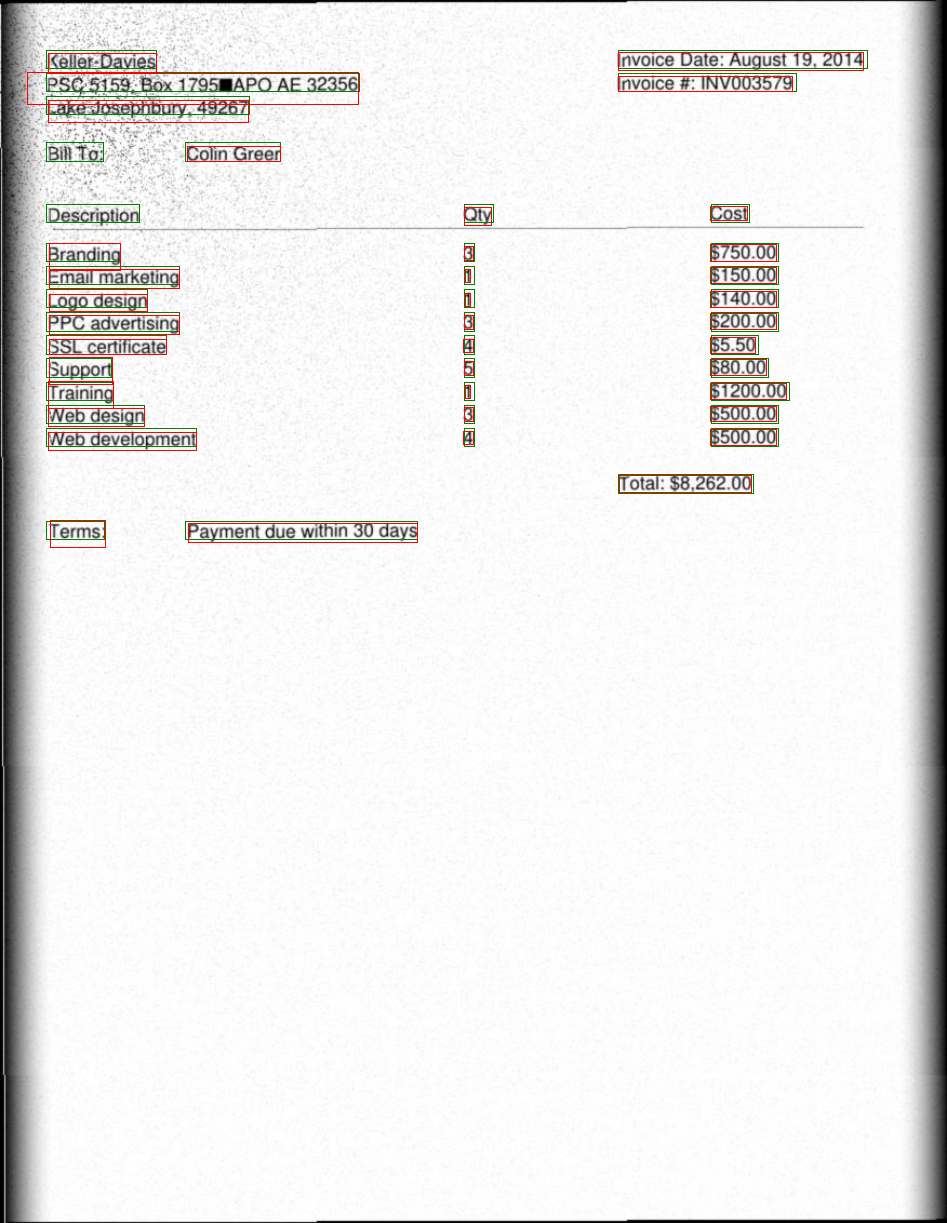

In [14]:
image_copy = noisy_image.copy()
draw_boxes(image_copy, scaled_data, color='green')
draw_boxes(image_copy, response, color='red')

In [15]:
# Show how predictions are sorted to match the ground truth
sort_predictions(scaled_data, response, draw=True)


[{'position': [48, 53, 156, 73], 'text': 'Keller-Davies'},
 {'position': [618, 52, 863, 70], 'text': 'Invoice Date: August 19, 2014'},
 {'position': [618, 76, 792, 91], 'text': 'Invoice #: INVO03579'},
 {'position': [27, 72, 358, 104], 'text': 'PS $159, Box 1795M)APO AE 32356'},
 {'position': [48, 100, 248, 122], 'text': ' kakedosephbury, 49267'},
 {},
 {'position': [187, 146, 280, 161], 'text': 'Colin Greer'},
 {},
 {'position': [464, 207, 491, 225], 'text': 'Qty'},
 {'position': [710, 206, 747, 220], 'text': 'Cost'},
 {'position': [49, 243, 120, 270], 'text': 'Branding'},
 {'position': [464, 246, 473, 260], 'text': '3'},
 {'position': [710, 244, 776, 261], 'text': '$750.00'},
 {'position': [49, 269, 179, 288], 'text': 'Email marketing'},
 {'position': [465, 269, 470, 282], 'text': '1'},
 {'position': [710, 267, 776, 283], 'text': '$150.00'},
 {'position': [49, 294, 147, 311], 'text': 'Logo design'},
 {'position': [465, 293, 470, 306], 'text': '1'},
 {'position': [710, 291, 776, 307],

In [16]:
# Test the reward function with slightly modified image data
reward(scaled_data, response, time_elapsed)

2023-12-14 13:24:21.924 |       INFO       | text: 1.000, position: 0.679, font: 0.000, total: 0.560
2023-12-14 13:24:21.926 |       INFO       | text: 1.000, position: 0.820, font: 0.000, total: 0.607
2023-12-14 13:24:21.926 |       INFO       | text: 0.950, position: 0.795, font: 0.000, total: 0.582
2023-12-14 13:24:21.926 |       INFO       | text: 0.871, position: 0.555, font: 0.000, total: 0.475
2023-12-14 13:24:21.926 |       INFO       | text: 0.818, position: 0.589, font: 0.000, total: 0.469
2023-12-14 13:24:21.926 |       INFO       | text: 0.000, position: 0.000, font: 0.000, total: 0.000
2023-12-14 13:24:21.926 |       INFO       | text: 1.000, position: 0.803, font: 0.000, total: 0.601
2023-12-14 13:24:21.927 |       INFO       | text: 0.000, position: 0.000, font: 0.000, total: 0.000
2023-12-14 13:24:21.927 |       INFO       | text: 1.000, position: 0.733, font: 0.000, total: 0.578
2023-12-14 13:24:21.927 |       INFO       | text: 1.000, position: 0.686, font: 0.000, tot

tensor(0.5845)